<a href="https://colab.research.google.com/github/petr-ngn/CNN_Real_Estate_Offices_Amenities_Listing/blob/main/04_Live_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import tensorflow as tf
import pandas as pd
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import sys
from google.colab import drive
import pickle

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
sys.path.append('/content/drive/MyDrive/Agile_ML/src_PN')

In [4]:
path = '/content/drive/MyDrive/Agile_ML'
os.chdir(path)

In [5]:
import PN_functions as PN

In [6]:
random_seed = 1234

Setting path to the live demo images' folders

In [7]:
team_photos_path = './team_images/'
reference_photos_path = './reference_imgs/'

Accessing images' names

In [8]:
team_photos_names = os.listdir(team_photos_path)
reference_photos_names = os.listdir(reference_photos_path)

In [9]:
print(f"team photos' names: {team_photos_names}")
print(f"rerefence photos' names: {reference_photos_names}")

team photos' names: ['PH.jpg', 'DM.jpg', 'RP.jpg', 'NM.jpg', 'PN.jpg']
rerefence photos' names: ['BO_01.jpg', 'BO_02.jpg', 'BO_03.jpg', 'BO_04.jpg', 'BO_05.jpg']


Plotting the team member's and reference images

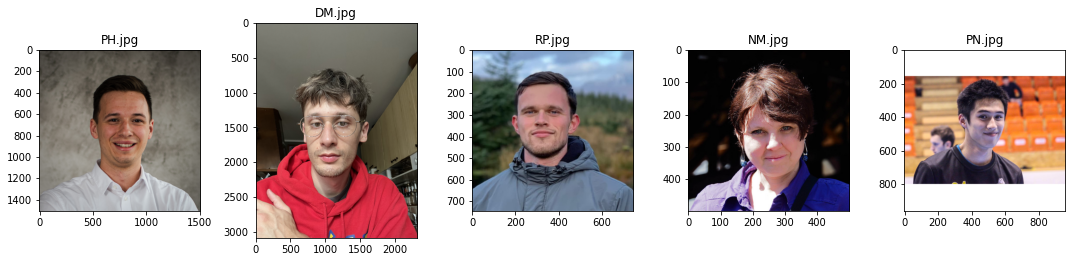

In [11]:
PN.plot_single_images(team_photos_names, team_photos_path)

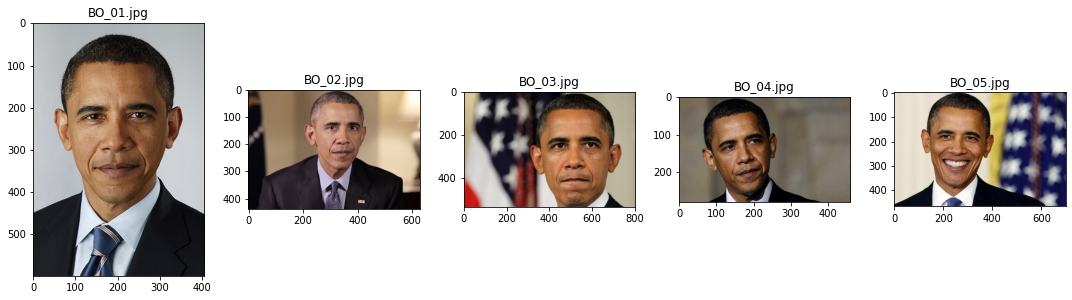

In [12]:
PN.plot_single_images(reference_photos_names, reference_photos_path)

Storing both of the the images types into a data frame as pairs

Plotting the pairs

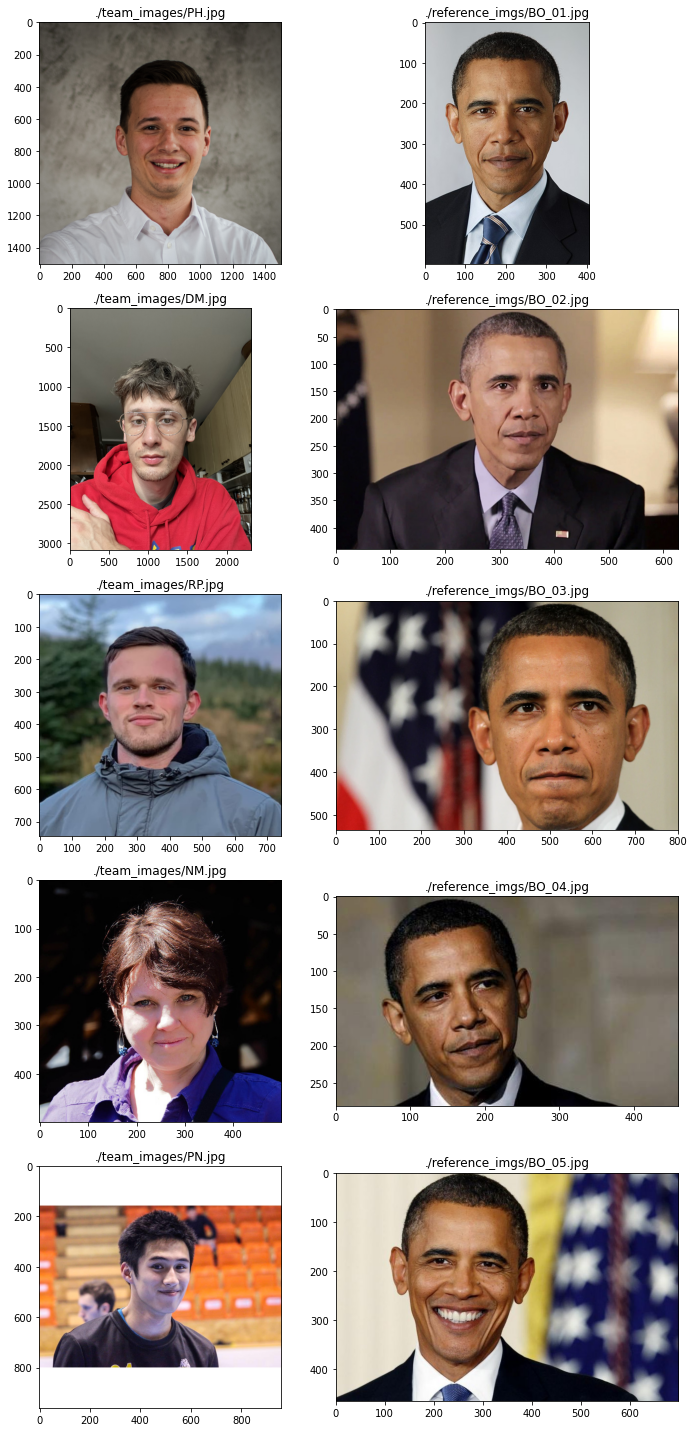

In [14]:
PN.plot_pairs(team_photos_names, reference_photos_names,
              team_photos_path, reference_photos_path,
              5, 2, (10,20))

Cropping the images

In [16]:
team_photos_cropped = PN.cropping_engine(team_photos_path, team_photos_names)

In [17]:
reference_photos_cropped = PN.cropping_engine(reference_photos_path, reference_photos_names)

Plotting the cropped images

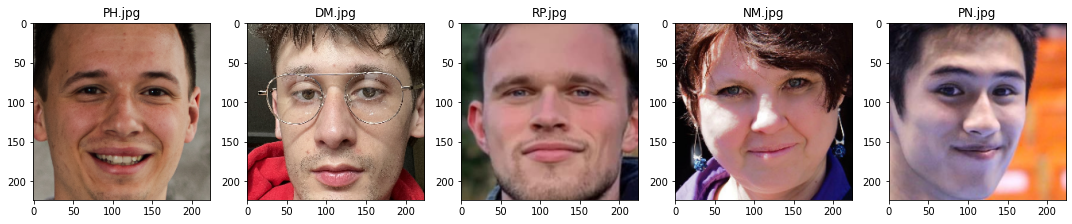

In [18]:
PN.plot_single_images(photos_dict = team_photos_cropped)

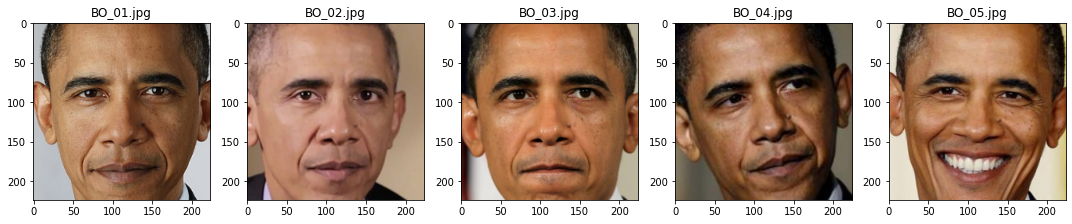

In [19]:
PN.plot_single_images(photos_dict = reference_photos_cropped)

Saving the cropped images

In [20]:
if not os.path.exists('./cropped_live_demo/'):
    os.makedirs('./cropped_live_demo/')

In [21]:
for name, photo in team_photos_cropped.items():
    cv2.imwrite(f'./cropped_live_demo/{name}', photo)

In [22]:
for name, photo in reference_photos_cropped.items():
    cv2.imwrite(f'./cropped_live_demo/{name}', photo)

Loading and extracting the cropped images' names

In [23]:
cropped_list = os.listdir('./cropped_live_demo/')

In [24]:
ref_init = 'BO'

In [25]:
barack_obama_list = [i for i in cropped_list if ref_init in i]
team_list = [i for i in cropped_list if ref_init not in i]

In [26]:
print(barack_obama_list)
print(team_list)

['BO_03.jpg', 'BO_01.jpg', 'BO_04.jpg', 'BO_02.jpg', 'BO_05.jpg']
['PH.jpg', 'RP.jpg', 'PN.jpg', 'DM.jpg', 'NM.jpg']


Creating a data frame with the pairs and the labels

In [66]:
df_pairs = pd.DataFrame({'img_1': team_photos_names,
              'img_2': reference_photos_names,
              'label':[0 for i in range(len(team_photos_names))]})

In [64]:
df_pairs

,img_1,img_2,label,pred,preds
0,PH.jpg,BO_01.jpg,0,0,0
1,DM.jpg,BO_02.jpg,0,1,1
2,RP.jpg,BO_03.jpg,0,0,0
3,NM.jpg,BO_04.jpg,0,0,0
4,PN.jpg,BO_05.jpg,0,1,1


Extracting the images and the labels into arrays

In [33]:
imgs, labels = PN.pairs_to_array(df_pairs)

Processing the cropped (left and right) images into tensors

In [34]:
left_imgs = PN.tf_single_prep(imgs[:,0])
right_imgs = PN.tf_single_prep(imgs[:,1])

Loading the final Siamese model

In [35]:
final_model = tf.keras.models.load_model('Siamese_NN_.h5',
                                         custom_objects = {'contrastive__loss':PN.contrastive_loss})

Extracting the CNN embedding

In [36]:
CNN_model = final_model.get_layer('CNN')

Predicting feature vectors (distances) for left and rights images

In [37]:
left_feat_vecs = CNN_model.predict(left_imgs)
right_feat_vecs = CNN_model.predict(right_imgs)

1/1 [==============================] - 0s 34ms/step


Loading the calculated cutoffs from the training / validation / training-validation / test sets

In [38]:
with open('cutoff_dict.pkl','rb') as f:
  cutoff_dict = pickle.load(f)

For each cutoff, calculate the respective accuracy

In [39]:
for name, cutoff in cutoff_dict.items():
  
  acc, preds, pred_distances = PN.compute_accuracy(labels,
                                                   left_feat_vecs,
                                                   right_feat_vecs,
                                                   cutoff)
  
  print(f'{name} ... cutoff: {cutoff} | accuracy: {acc*100:.2f}%')

train ... cutoff: 2.772153377532959 | accuracy: 40.00%
valid ... cutoff: 2.761025905609131 | accuracy: 40.00%
train_valid ... cutoff: 2.768815279006958 | accuracy: 40.00%
test ... cutoff: 2.759225845336914 | accuracy: 40.00%


Assigning predicted labels

In [67]:
df_pairs['pred'] = [lab if pred == True else 0 if lab == 1 else 1 for lab, pred in zip(df_pairs['label'],preds)]
df_pairs

,img_1,img_2,label,pred
0,PH.jpg,BO_01.jpg,0,0
1,DM.jpg,BO_02.jpg,0,1
2,RP.jpg,BO_03.jpg,0,0
3,NM.jpg,BO_04.jpg,0,0
4,PN.jpg,BO_05.jpg,0,1


Plotting the pairs and the predicted/true labels

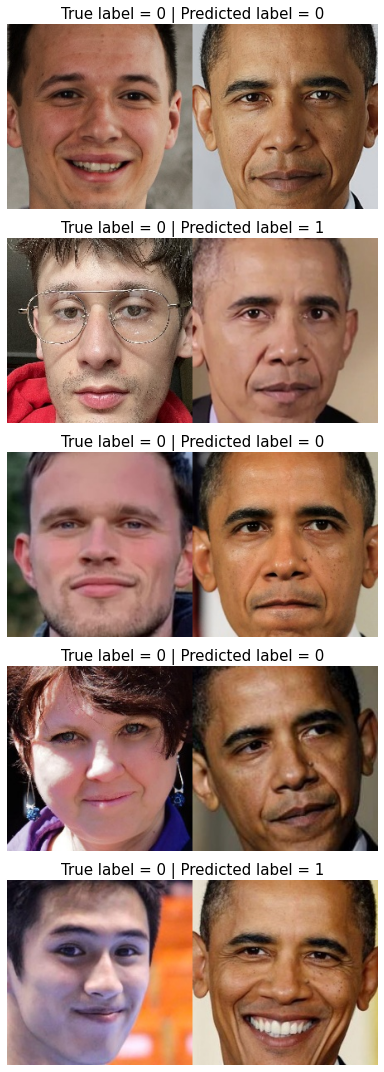

In [70]:
fig, axs = plt.subplots(5, 1, figsize=(20, 15))
for i_row, ax in zip(df_pairs.iterrows(), axs.ravel()):
  ax.imshow(tf.concat([cv2.cvtColor(cv2.imread('./cropped_live_demo/'+i_row[1]["img_1"]), cv2.COLOR_BGR2RGB),
                      cv2.cvtColor(cv2.imread('./cropped_live_demo/'+i_row[1]["img_2"]), cv2.COLOR_BGR2RGB)
                      ],axis = 1))
  ax.set_title(f'True label = {i_row[1]["label"]} | Predicted label = {i_row[1]["pred"]}',
               size = 15)
  ax.set_axis_off()
  
plt.tight_layout()
plt.show()
